In [2]:
from __future__ import division
from past.utils import old_div
from SIPPY import functionset as fset
from SIPPY import *
import numpy as np
import control.matlab as cnt
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (9.0, 5.0)
%matplotlib nbagg

## Define sampling time and Time vector

In [3]:
sampling_time = 1.  # [s]
end_time = 400  # [s]
npts = int(old_div(end_time, sampling_time)) + 1
Time = np.linspace(0, end_time, npts)

## Define pseudo random binary sequence as input signal and white noise as noise signal

In [4]:
switch_probability = 0.08  # [0..1]
Usim = fset.PRBS_seq(npts, switch_probability)
white_noise_variance = [0.005]
e_t = fset.white_noise_var(Usim.size, white_noise_variance)[0]

## Define the system

### Numerator of noise transfer function has only one root: nc = 1

In [5]:
NUM_H = [1., 0.3, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

### Common denominator between input and noise transfer functions has 4 roots: na = 4

In [6]:
DEN = [1., -2.21, 1.7494, -0.584256, 0.0684029, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

### Numerator of input transfer function has 3 roots: nb = 3

In [7]:
NUM = [1., -2.07, 1.3146]

### Define transfer functions

In [8]:
g_sample = cnt.tf(NUM, DEN, sampling_time)
h_sample = cnt.tf(NUM_H, DEN, sampling_time)
display(g_sample)
display(h_sample)


                  z^2 - 2.07 z + 1.315
---------------------------------------------------------
z^14 - 2.21 z^13 + 1.749 z^12 - 0.5843 z^11 + 0.0684 z^10

dt = 1.0


                     z^14 + 0.3 z^13
---------------------------------------------------------
z^14 - 2.21 z^13 + 1.749 z^12 - 0.5843 z^11 + 0.0684 z^10

dt = 1.0

## Time responses

### Input reponse

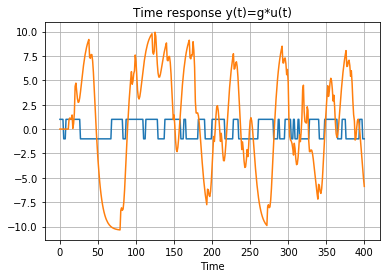

In [9]:
Y1, Time, Xsim = cnt.lsim(g_sample, Usim, Time)
plt.figure()
plt.plot(Time, Usim)
plt.plot(Time, Y1)
plt.xlabel("Time")
plt.title("Time response y(t)=g*u(t)")
plt.grid()

### Noise response

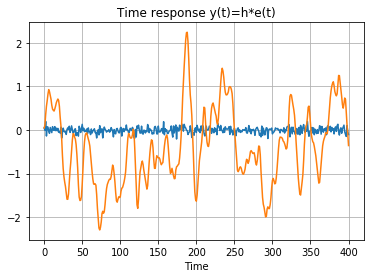

In [10]:
Y2, Time, Xsim = cnt.lsim(h_sample, e_t, Time)
plt.figure()
plt.plot(Time, e_t)
plt.plot(Time, Y2)
plt.xlabel("Time")
plt.title("Time response y(t)=h*e(t)")
plt.grid()

## Compute total output 
$$Y_t = Y_1 + Y_2 = G.u + H.e$$

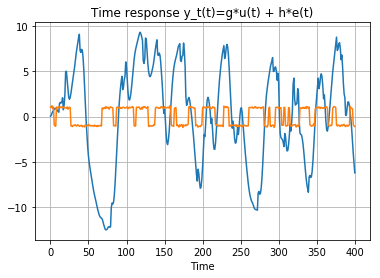

In [11]:
Ytot = Y1 + Y2
Utot = Usim + e_t
plt.figure()
plt.plot(Time, Ytot)
plt.plot(Time, Utot)
plt.xlabel("Time")
plt.title("Time response y_t(t)=g*u(t) + h*e(t)")
plt.grid()

## Perform system identification from collected data

In [12]:
Id_sys = system_identification(Ytot, Usim, 'ARMAX', IC='BIC', na_ord=[2, 5], \
                               nb_ord=[1, 5], nc_ord=[0, 2], delays=[10, 13], \
                               ARMAX_max_iterations=300)

suggested orders are: Na= 4 ; Nb= 3 ; Nc= 1 Delay:  11


## Check that output of the identified system is consistent

In [13]:
Y_id1, Time, Xsim = cnt.lsim(Id_sys.G, Usim, Time)
Y_hid1, Time, Xsim = cnt.lsim(Id_sys.H, e_t, Time)
Y_idTot = Y_id1 + Y_hid1

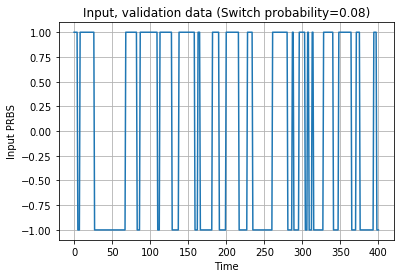

In [14]:
plt.figure(0)
plt.plot(Time, Usim)
plt.ylabel("Input PRBS")
plt.xlabel("Time")
plt.title("Input, validation data (Switch probability=0.08)")
plt.grid()

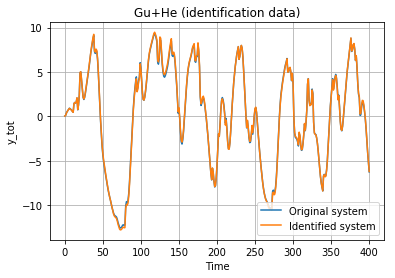

In [15]:
plt.figure(1)
plt.plot(Time, Ytot)
plt.plot(Time, Y_idTot)
plt.grid()
plt.xlabel("Time")
plt.ylabel("y_tot")
plt.title("Gu+He (identification data)")
plt.legend(['Original system', 'Identified system'])

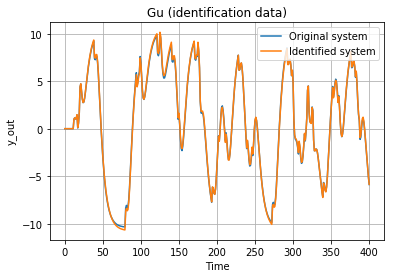

In [16]:
plt.figure(2)
plt.plot(Time, Y1)
plt.plot(Time, Y_id1)
plt.ylabel("y_out")
plt.grid()
plt.xlabel("Time")
plt.title("Gu (identification data)")
plt.legend(['Original system', 'Identified system'])

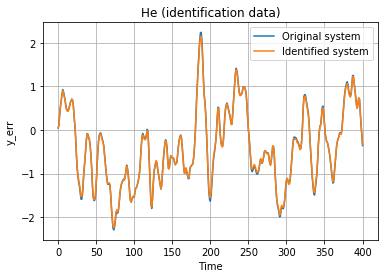

In [17]:
plt.figure(3)
plt.plot(Time, Y2)
plt.plot(Time, Y_hid1)
plt.ylabel("y_err")
plt.grid()
plt.xlabel("Time")
plt.title("He (identification data)")
plt.legend(['Original system', 'Identified system'])

# Validation of the identified system: 
## Generate new time series for input and noise

In [18]:
switch_probability = 0.07  # [0..1]
input_range = [0.5, 1.5]
U_valid = fset.PRBS_seq(npts, switch_probability, input_range)
white_noise_variance = [0.01]
e_valid = fset.white_noise_var(U_valid.size, white_noise_variance)[0]

## Compute time responses for true system with new inputs

In [19]:
Yvalid1, Time, Xsim = cnt.lsim(g_sample, U_valid, Time)
Yvalid2, Time, Xsim = cnt.lsim(h_sample, e_valid, Time)
Ytotvalid = Yvalid1 + Yvalid2

## Compute time responses for identified system with new inputs

In [20]:
Yidvalid1, Time, Xsim = cnt.lsim(Id_sys.G, U_valid, Time)
Yidvalid2, Time, Xsim = cnt.lsim(Id_sys.H, e_valid, Time)
Yidtotvalid = Yidvalid1 + Yidvalid2

## Check responses are almost equal

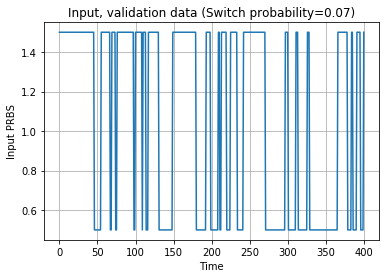

In [21]:
plt.figure(4)
plt.plot(Time, U_valid)
plt.ylabel("Input PRBS")
plt.xlabel("Time")
plt.title("Input, validation data (Switch probability=0.07)")
plt.grid()

Text(0.5,1,'Validation: Gu+He | RMSE = 0.38')

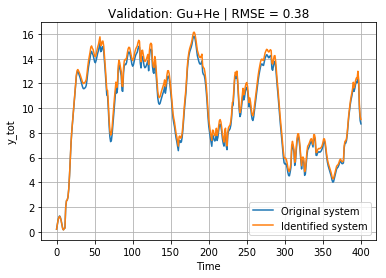

In [22]:
plt.figure(5)
plt.plot(Time, Ytotvalid)
plt.plot(Time, Yidtotvalid)
plt.xlabel("Time")
plt.ylabel("y_tot")
plt.legend(['Original system', 'Identified system'])
plt.grid()

rmse = np.round(np.sqrt(np.mean((Ytotvalid-Yidtotvalid)**2)), 2)
plt.title("Validation: Gu+He | RMSE = {}".format(rmse))

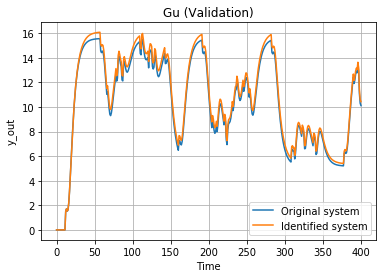

In [23]:
plt.figure(6)
plt.plot(Time, Yvalid1)
plt.plot(Time, Yidvalid1)
plt.grid()
plt.xlabel("Time")
plt.ylabel("y_out")
plt.title("Gu (Validation)")
plt.legend(['Original system', 'Identified system'])

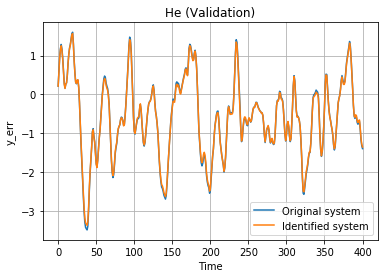

In [24]:
plt.figure(7)
plt.plot(Time, Yvalid2)
plt.plot(Time, Yidvalid2)
plt.grid()
plt.xlabel("Time")
plt.ylabel("y_err")
plt.title("He (Validation)")
plt.legend(['Original system', 'Identified system'])


                     z^14 + 0.3 z^13
---------------------------------------------------------
z^14 - 2.21 z^13 + 1.749 z^12 - 0.5843 z^11 + 0.0684 z^10

dt = 1.0


                    z^14 + 0.2718 z^13
----------------------------------------------------------
z^14 - 2.206 z^13 + 1.74 z^12 - 0.5747 z^11 + 0.06324 z^10

dt = 1.0

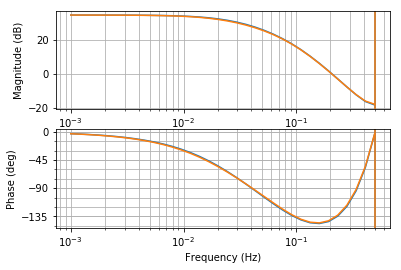

In [25]:
display(h_sample)
display(Id_sys.H)

plt.figure()
_ = cnt.bode([h_sample, Id_sys.H])


                  z^2 - 2.07 z + 1.315
---------------------------------------------------------
z^14 - 2.21 z^13 + 1.749 z^12 - 0.5843 z^11 + 0.0684 z^10

dt = 1.0


                1.002 z^2 - 2.069 z + 1.315
----------------------------------------------------------
z^14 - 2.206 z^13 + 1.74 z^12 - 0.5747 z^11 + 0.06324 z^10

dt = 1.0

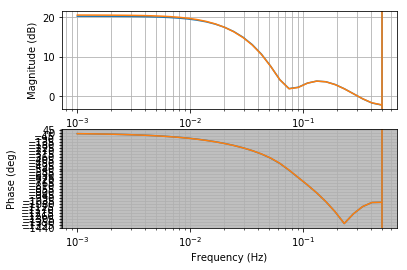

In [26]:
display(g_sample)
display(Id_sys.G)

plt.figure()
_ = cnt.bode([g_sample, Id_sys.G])